In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import yfinance as yf
import seaborn as sns
import matplotlib.dates as mdates
import warnings
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
from datetime import datetime
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

Import BBNI Data

In [3]:
TICKER = "BBNI.JK"

start_date = "2021-01-01"

# use UTC and converstion to local zone
utc_now = datetime.now()
local_tz = pytz.timezone("Asia/Jakarta")
local_now = utc_now.replace(tzinfo=pytz.utc).astimezone(local_tz)

end_date = local_now.strftime("%Y-%m-%d")

df = yf.download(TICKER, start=start_date, end=end_date)

print(f"Data BBNI.JK ({len(df)} days):")
print(df.tail())

[*********************100%***********************]  1 of 1 completed

Data BBNI.JK (1170 days):
Price        Close    High     Low    Open    Volume
Ticker     BBNI.JK BBNI.JK BBNI.JK BBNI.JK   BBNI.JK
Date                                                
2025-11-03  4430.0  4460.0  4380.0  4390.0  40455000
2025-11-04  4450.0  4510.0  4430.0  4430.0  73342900
2025-11-05  4460.0  4480.0  4380.0  4400.0  43447700
2025-11-06  4440.0  4480.0  4430.0  4450.0  31809500
2025-11-07  4500.0  4500.0  4440.0  4440.0  36148800


Feature Engineering

In [4]:
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df_clean = df.dropna().copy()

# define features and target
FEATURES = ['Close', 'Volume', 'SMA_20']
TARGET = 'Close'
NUM_FEATURES = len(FEATURES)

# normalize data
data_values = df_clean[FEATURES].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_values)

# define paramater for training
TIME_STEP = 60
TEST_SPLIT = 0.80
BATCH_SIZE = 64
EPOCHS = 100

In [5]:
# split data into train and test set
training_data_len = int(len(scaled_data) * TEST_SPLIT)
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len -  TIME_STEP:, :]

In [6]:
# create dataset function for time series
def create_dataset(data, time_step):
    X, y = [], []
    target_index = FEATURES.index(TARGET)
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, :]) # take all features for time steps
        y.append(data[i, target_index]) # only take target value in i step
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train, y_train = create_dataset(train_data, TIME_STEP)
X_test, y_test = create_dataset(test_data, TIME_STEP)

Model 1: LSTM

In [7]:
model_lstm = Sequential()
model_lstm.add(Input(shape=(TIME_STEP, NUM_FEATURES)))

# First Layer LSTM
model_lstm.add(LSTM(units=128, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Second Layer LSTM
model_lstm.add(LSTM(units=64, return_sequences=False))
model_lstm.add(Dropout(0.2))

# Dense Layer
model_lstm.add(Dense(units=32, activation='relu'))
model_lstm.add(Dense(units=1)) # output layer

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()

# callbacks: time-series friendly
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5 , patience=5, min_lr=0.00001, monitor='val_loss')
]

2025-11-07 18:17:32.393607: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-07 18:17:32.393654: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-07 18:17:32.393657: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-07 18:17:32.393694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-07 18:17:32.393706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,105 (465.25 KB)

 Trainable params: 119,105 (465.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# model fit

history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


2025-11-07 18:17:33.242466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0198 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0178 - val_loss: 0.0242 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0149 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0104 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0082 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0057 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0056 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0060 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0064 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 10/100
14/14 ━━━

Model 2: Gated Recurrent Unit (GRU)

In [9]:
model_gru = Sequential()
model_gru.add(Input(shape=(TIME_STEP, NUM_FEATURES)))

# First Layer GRU
model_gru.add(GRU(units=128, return_sequences=True))
model_gru.add(Dropout(0.2))

# Second Layer GRU
model_gru.add(GRU(units=64, return_sequences=False))
model_gru.add(Dropout(0.2))

# Dense Layer
model_gru.add(Dense(units=32, activation='relu'))
model_gru.add(Dense(units=1)) # output layer

model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 128)        │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,433 (353.25 KB)

 Trainable params: 90,433 (353.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# model fit

history_gru = model_gru.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0271 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0460 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0286 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0089 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0098 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0071 - val_loss: 0.0024 - learning_rate: 5.0000e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0069 - val_loss: 0.0025 - learning_rate: 5.0000e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0071 - val_loss: 0.0023 - learning_rate: 5.0000e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0063 - val_loss: 0.0024 - learning_rate: 5.000

Reporting Result

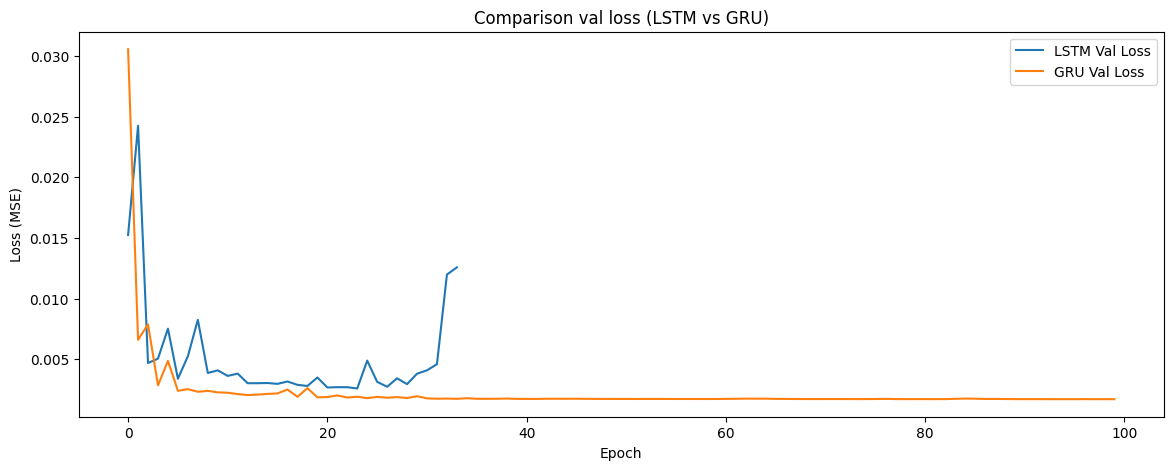

In [11]:
plt.figure(figsize=(14, 5))
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss')
plt.plot(history_gru.history['val_loss'], label='GRU Val Loss')
plt.title('Comparison val loss (LSTM vs GRU)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [12]:
# predict use best model
target_idx = FEATURES.index(TARGET)

# predict LSTM
lstm_predictions_scaled = model_lstm.predict(X_test)
dummy_pred = np.zeros((len(y_test), NUM_FEATURES))
dummy_pred[:, target_idx] = lstm_predictions_scaled.ravel()
lstm_predictions = scaler.inverse_transform(dummy_pred)[:, target_idx]

# predict GRU
gru_predictions_scaled = model_gru.predict(X_test)
dummy_pred[:, target_idx] = gru_predictions_scaled.ravel()
gru_predictions = scaler.inverse_transform(dummy_pred)[:, target_idx]

# actual price
dummy_actual = np.zeros((len(y_test), NUM_FEATURES))
dummy_actual[:, target_idx] = y_test.ravel()
actual_test_prices = scaler.inverse_transform(dummy_actual)[:, target_idx]

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


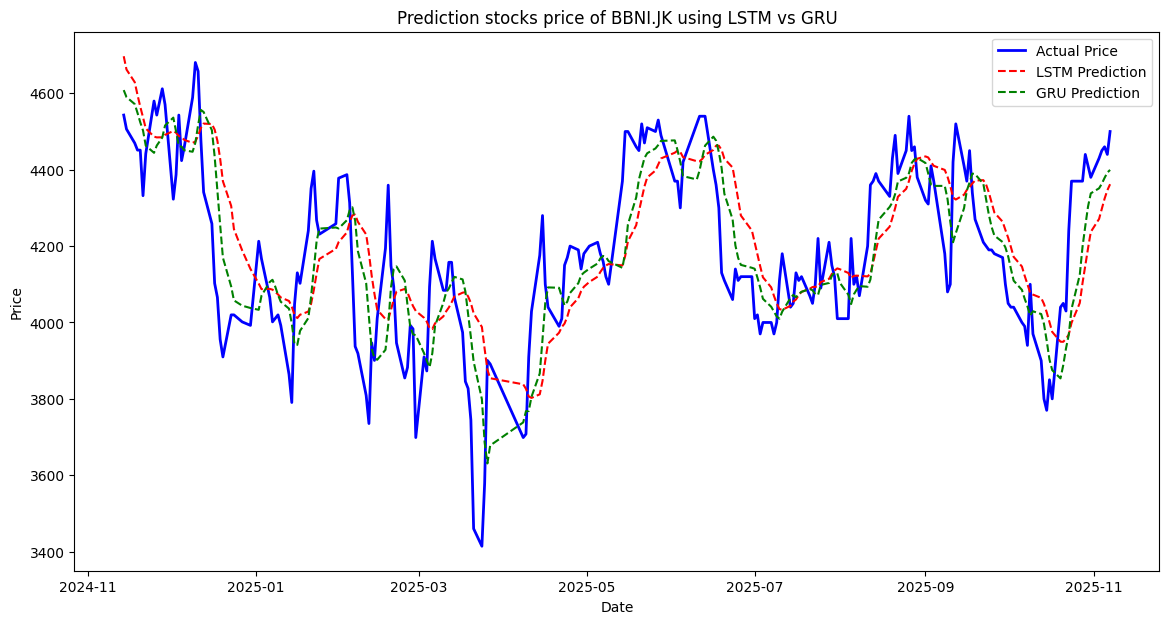

In [13]:
# visualization comparison prediction

df_results = df_clean.iloc[-len(y_test):].copy()

# add columns for actual and predicted prices
df_results['Actual'] = actual_test_prices
df_results['LSTM_Prediction'] = lstm_predictions
df_results['GRU_Prediction'] = gru_predictions

plt.figure(figsize=(14, 7))
plt.plot(df_results.index, df_results['Actual'], label='Actual Price', color='blue', linewidth=2)
plt.plot(df_results.index, df_results['LSTM_Prediction'], label='LSTM Prediction', color='red', linestyle='--')
plt.plot(df_results.index, df_results['GRU_Prediction'], label='GRU Prediction', color='green', linestyle='--')
plt.title(f'Prediction stocks price of {TICKER} using LSTM vs GRU')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
def prediction():
    try:
        # prediction logic
        mse_lstm = mean_squared_error(actual_test_prices, lstm_predictions)
        rmse_lstm = np.sqrt(mse_lstm)
        r2_lstm = r2_score(actual_test_prices, lstm_predictions)
        mape_lstm = mean_absolute_percentage_error(actual_test_prices, lstm_predictions) * 100

        mse_gru = mean_squared_error(actual_test_prices, gru_predictions)
        rmse_gru = np.sqrt(mse_gru)
        r2_gru = r2_score(actual_test_prices, gru_predictions)
        mape_gru = mean_absolute_percentage_error(actual_test_prices, gru_predictions) * 100

        results_metrics = pd.DataFrame({
            'Metric': ['MSE', 'RMSE', 'R2', 'MAPE'],
            'LSTM': [mse_lstm, rmse_lstm, r2_lstm, mape_lstm],
            'GRU': [mse_gru, rmse_gru, r2_gru, mape_gru]
        })
        return results_metrics
        
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

# call the prediction function and print results
results = prediction()
print(results)

  Metric          LSTM           GRU
0    MSE  33169.972084  21881.573453
1   RMSE    182.126253    147.924215
2     R2      0.386204      0.595091
3   MAPE      3.586584      2.856649


In [15]:
future_predictions_df = pd.DataFrame({
    'Date': df_results.index,
    'Actual': df_results['Actual'],
    'LSTM_Prediction': df_results['LSTM_Prediction'],
    'GRU_Prediction': df_results['GRU_Prediction']
})

future_predictions_df.tail()

,Date,Actual,LSTM_Prediction,GRU_Prediction
Date,,,,
2025-11-03,2025-11-03,4430.000074,4271.013152,4351.286656
2025-11-04,2025-11-04,4450.000092,4297.765237,4363.375510
2025-11-05,2025-11-05,4460.000102,4324.196616,4378.607109
2025-11-06,2025-11-06,4440.000083,4346.032919,4392.411931
2025-11-07,2025-11-07,4499.999925,4362.021136,4399.456380


In [16]:
df_results['SMA_20'].head()

Date
2024-11-14    4864.743726
2024-11-15    4830.785498
2024-11-18    4796.138940
2024-11-19    4759.427344
2024-11-20    4721.568506
Name: SMA_20, dtype: float64